In [2]:
import casatools
import casatasks

In [68]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.constants import c
from functools import partial
from scipy.spatial import cKDTree
from tqdm import tqdm

In [4]:
fname = "/home/mjybarth/scratch/dsharp/HTLup_continuum.ms"
fitsname = "AS209.fits"

In [5]:
tb = casatools.table()
ms = casatools.ms()

In [6]:
tb.open(fname)
colnames = tb.colnames()
tb.close()
print(colnames)

['UVW', 'FLAG', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'WEIGHT_SPECTRUM', 'SIGMA_SPECTRUM', 'MODEL_DATA']


In [29]:
tb.open(fname + "/DATA_DESCRIPTION")
SPECTRAL_WINDOW_ID = tb.getcol("SPECTRAL_WINDOW_ID")
tb.close()
print(SPECTRAL_WINDOW_ID)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [52]:
vis = []
uu = []
vv = []
for spw_id in SPECTRAL_WINDOW_ID:
    ms.open(fname)
    # select the spectral window
    ms.selectinit(datadescid=spw_id, reset=True)
    # query the desired columnames as a list
    query = ms.getdata(["MODEL_DATA", "u", "v"])
    
    # always a good idea to reset the earmarked data
    ms.selectinit(reset=True)
    ms.close()
    vis_1 = np.array(query["model_data"])
    u = np.zeros(vis_1.shape)
    v = np.zeros(vis_1.shape)
    msmd.open(fname)
    chan_freq = msmd.chanfreqs(spw_id)
    msmd.done()
    for i in range(vis_1.shape[1]):
        u[0, i] = np.array(query["u"]) * (np.mean(chan_freq)/c)
        v[0, i] = np.array(query["v"]) * (np.mean(chan_freq)/c)
        u[1, i] = np.array(query["u"]) * (np.mean(chan_freq)/c)
        v[1, i] = np.array(query["v"]) * (np.mean(chan_freq)/c)
    vis += [vis_1.flatten()]
    uu += [u.flatten()]
    vv += [v.flatten()]

In [53]:
vis = np.concatenate(vis)
uu = np.concatenate(uu)
vv = np.concatenate(vv)
weight = np.ones(len(uu))

/home/mjybarth/envs/mpol/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


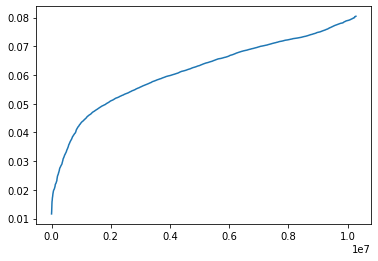

In [50]:
plt.plot(np.linspace(0, len(vis), len(vis)), np.sort(vis))

In [54]:
chans_per_spw = np.array([8, 16, 16, 16, 8, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 8]) # need to read those from CASA in the future

n_spw = len(vis_per_spw)
# print(n_spw)
#spw = 13 # pick spectral window
#print(vis_per_spw[spw])

idx_freq = np.cumsum(chans_per_spw)
idx_freq_inf = 0
#if spw == 0: 
#    idx_freq_inf = 0
#else: 
#    idx_freq_inf = idx_freq[spw-1]
idx_freq_sup = idx_freq[-1]
freqs_spw = freq_per_spw[idx_freq_inf:idx_freq_sup]
freq = np.mean(freqs_spw)

#idx_inf = vis_per_spw[:spw-1].sum()
#idx_sup = vis_per_spw[:spw].sum()
#u = u[idx_inf:idx_sup]
#v = v[idx_inf:idx_sup]
#vis = vis[idx_inf:idx_sup]
#weight = weight[idx_inf:idx_sup]

# Noé don't forget your minus signs when taking Hermitian conjugates
uu = np.concatenate([uu, -uu])
vv = np.concatenate([vv, -vv])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, -vis.imag])
weight = np.ones(len(uu))
weight_ = np.concatenate([weight, weight])

In [93]:
def grid(pixel_scale, img_size): 
    """Given a pixel scale and a number of pixels in image space, grid the associated Fourier space

    Args:
        pixel_scale (float): Pixel resolution (in arcsec)
        img_size (float/int): Size of the image 

    Returns:
        
    """

    # Arcsec to radians: 
    dl = pixel_scale * (1/3600) * (np.pi/180)
    dm = pixel_scale * (1/3600) * (np.pi/180)

    du = 1 / (img_size * dl) * 1e-3 # klambda
    dv = 1 / (img_size * dm) * 1e-3 # klambda

    u_min = -img_size//2 * du 
    u_max = img_size//2 * du 

    v_min = -img_size//2 * dv
    v_max = img_size//2 * dv

    u_edges = np.linspace(u_min, u_max, img_size + 1)
    v_edges = np.linspace(v_min, v_max, img_size + 1)

    return u_edges, v_edges


def plot_uv_coverage(u, v, grid = False): 
    # Plot the uv coverage, if grid = True, plot the associated grid
    plt.scatter(u, v, s=0.5, rasterized=True, linewidths=0.0, c="r")

    if grid: 
        for x_coord in u_edges: 
            plt.axvline(x = x_coord, color = "gray", linestyle = "-", alpha = 1)

        for y_coord in v_edges:
            plt.axhline(y =y_coord, color = "gray", linestyle = "-", alpha = 1)
        

    plt.xlim([u.min(), u.max()])
    plt.ylim([v.min(), v.max()])
    plt.gca().set_aspect("equal")
    

In [58]:
pixel_scale = 0.0015
# pad = 768//2 # padding to 1024 pixels
pad = (4096 - 256)//2 # padding to 2048
# pad = 128 # padding to 512
img_size = 256
npix = img_size + 2 * pad
u_edges, v_edges = grid(pixel_scale = pixel_scale, img_size = npix)
pixel_size = u_edges[1] - u_edges[0] # this is delta_u, and we should probably call it that in the future. My bad

In [59]:
def pillbox_window(u, center, pixel_size=pixel_size, m=1):
    """
    u: coordinate of the data points to be aggregated (u or v)
    center: coordinate of the center of the pixel considered. 
    pixel_size: Size of a pixel in the (u,v)-plane
    m: size of the truncation of this window (in term of pixel_size)
    """
    return np.where(np.abs(u - center) <= m * pixel_size / 2, 1, 0)


def sinc_window(u, center, pixel_size=pixel_size, m=1):
    """
    u: coordinate of the data points to be aggregated (u or v)
    center: coordinate of the center of the pixel considered. 
    pixel_size: Size of a pixel in the (u,v)-plane
    m: size of the truncation of this window (in term of pixel_size)
    """
    return np.sinc(np.abs(u - center) / m / pixel_size)

In [60]:
from typing import Callable
def bin_data(u, v, values, weights, bins, window_fn, truncation_radius, statistics_fn="mean", verbose=0):
    u_edges = bins[0]
    v_edges = bins[1]
    n_coarse = 0
    grid = np.zeros((len(u_edges)-1, len(v_edges)-1))
    if verbose:
        print("Fitting the KD Tree on the data...")
    # Build a cKDTree from the data points coordinates to query uv points in our truncation radius
    uv_grid = np.vstack((u.ravel(), v.ravel())).T
    tree = cKDTree(uv_grid)
    if verbose:
        print("Gridding...")
    for i in tqdm(range(len(u_edges)-1), disable=not verbose):
        for j in range(len(v_edges)-1):
            # Calculate the coordinates of the center of the current cell in our grid
            u_center = (u_edges[i] + u_edges[i+1])/2
            v_center = (v_edges[j] + v_edges[j+1])/2
            # Query the tree to find the points within the truncation radius of the cell
            indices = tree.query_ball_point([u_center, v_center], truncation_radius, p=1) # p=1 is the Manhattan distance (L1)
            # Apply the convolutional window and weighted averaging
            if len(indices) > 0:
                value = values[indices]
                weight = weights[indices] * window_fn(u[indices], u_center) * window_fn(v[indices], v_center)
                #if len(indices) == 1 and verbose > 1:
                    #print(f"Cell {(i, j)} has a single visibility and weight {weight.sum()} {weight}...")
                if weight.sum() > 0.: # avoid dividing by a normalization = 0
                    if statistics_fn=="mean":
                        grid[j, i] = (value * weight).sum() / weight.sum()
                    elif statistics_fn=="std":
                        m = 1
                        if (weight > 0).sum() < 5:
                            # run statistics on a larger neighborhood
                            while (weight > 0).sum() < 5: # this number is a bit arbitrary, we just hope to get better statistics
                                m += 0.1
                                indices = tree.query_ball_point([u_center, v_center], m*truncation_radius, p=1) # p=1 is the Manhattan distance (L1)
                                value = values[indices]
                                weight = weights[indices] * window_fn(u[indices], u_center, m = m) * window_fn(v[indices], v_center, m = m)
                            #print(f"Coarsened pixel to {m} times its size, now has {len(indices)} for statistics")
                            n_coarse += 1
                        # See https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
                        # See more specifically the bootstrapping
                        if np.sum(weight > 0) < 2:
                            print("Low weight")
                        
                        #N_eff taken from Bevington, see the page: http://seismo.berkeley.edu/~kirchner/Toolkits/Toolkit_12.pdf
                        importance_weights = window_fn(u[indices], u_center, m = m) * window_fn(v[indices], v_center, m = m)
                        n_eff = np.sum(importance_weights)**2 / np.sum(importance_weights**2)
                        grid[j, i] = np.sqrt(np.cov(value, aweights=weight, ddof = 0)) * (n_eff / (n_eff - 1)) * 1/(np.sqrt(n_eff))
                    elif statistics_fn=="count":
                        grid[j, i] = (weight > 0).sum()
                    elif isinstance(statistics_fn, Callable):
                        grid[j, i] = statistics_fn(value, weight)
    print(f"number of coarsened pix: {n_coarse}")
    return grid

In [69]:
truncation_radius = pixel_size
window_fn = partial(sinc_window, pixel_size=pixel_size)

# Real part mean and count
args = (uu, vv, vis_re, weight_, (u_edges, v_edges), window_fn, truncation_radius)
vis_bin_re = bin_data(*args, statistics_fn="mean", verbose=1)
std_bin_re = bin_data(*args, statistics_fn="std", verbose=2)
counts = bin_data(*args, statistics_fn="count", verbose=1)

# Image part mean
args = (uu, vv, vis_imag, weight_, (u_edges, v_edges), window_fn, truncation_radius)
vis_bin_imag = bin_data(*args, statistics_fn="mean", verbose=1)
std_bin_imag = bin_data(*args, statistics_fn="std", verbose=2)

Fitting the KD Tree on the data...
Gridding...


100%|██████████| 4096/4096 [02:45<00:00, 24.69it/s]


number of coarsened pix: 0
Fitting the KD Tree on the data...
Gridding...


100%|██████████| 4096/4096 [02:47<00:00, 24.39it/s]


number of coarsened pix: 0
Fitting the KD Tree on the data...
Gridding...


100%|██████████| 4096/4096 [02:45<00:00, 24.81it/s]


number of coarsened pix: 0
Fitting the KD Tree on the data...
Gridding...


100%|██████████| 4096/4096 [02:45<00:00, 24.73it/s]


number of coarsened pix: 0
Fitting the KD Tree on the data...
Gridding...


100%|██████████| 4096/4096 [02:50<00:00, 24.09it/s]


number of coarsened pix: 0


In [70]:
np.save("data/clean_re", vis_bin_re)
np.save("data/clean_re_std", std_bin_re)
np.save("data/clean_counts", counts)
np.save("data/clean_imag", vis_bin_imag)
np.save("data/clean_imag_std", std_bin_imag)

In [ ]:
vis_bin_re = np.load("data/clean_re.npy")
std_bin_re = np.load("data/clean_re_std.npy")
counts = np.load("data/clean_counts.npy")
vis_bin_imag = np.load("data/clean_imag.npy")
std_bin_imag = np.load("data/clean_imag_std.npy")

In [71]:
# From object type to float
vis_bin_re = vis_bin_re.astype(float)
vis_bin_imag = vis_bin_imag.astype(float)
std_bin_re = std_bin_re.astype(float) 
std_bin_imag = std_bin_imag.astype(float)
counts = counts.astype(float)

# i.e. The sampling function where there is data in the uv plane
mask = counts > 0

# Upsample std 
from scipy import interpolate
def upsample(input_data, d):
    # Get the shape of the input grid
    rows, cols = input_data.shape
    # Define the x and y coordinates of the original grid
    x = np.linspace(0, cols - 1, cols)
    y = np.linspace(0, rows - 1, rows)
    
    # Create a bilinear interpolator object
    f_interp = interpolate.interp2d(x, y, input_data, kind='linear')
    
    # Define the x and y coordinates of the upsampled grid
    x_new = np.linspace(0, cols - 1, cols * d)
    y_new = np.linspace(0, rows - 1, rows * d)
    
    # Perform the interpolation to upsample the grid
    upsampled_data = f_interp(x_new, y_new)
    return upsampled_data

# upsample std if needed
if std_bin_re.shape[0] < vis_bin_re.shape[0]:
    assert vis_bin_re.shape[0] // std_bin_re.shape[0] == downsampling_factor
    std_bin_re = upsample(std_bin_re, downsampling_factor)
if std_bin_imag.shape[0] < vis_bin_imag.shape[0]:
    assert vis_bin_imag.shape[0] // std_bin_imag.shape[0] == downsampling_factor
    std_bin_imag = upsample(std_bin_imag, downsampling_factor)

#I am commenting this out and performing this process inside the binning function
#std_bin_re /= (counts + 1)**0.5
#std_bin_imag /= (counts + 1)**0.5

# For the inference, fftshift is done in the forward model
vis_gridded_re = np.fft.fftshift(vis_bin_re).flatten()
vis_gridded_imag = np.fft.fftshift(vis_bin_imag).flatten()
std_gridded_re = np.fft.fftshift(std_bin_re).flatten()
std_gridded_imag = np.fft.fftshift(std_bin_imag).flatten()
S_grid = np.fft.fftshift(mask).flatten()

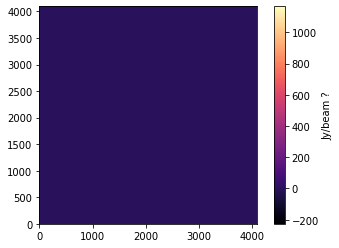

In [72]:
def plot_dirty_image(vis_gridded): 
    dirty_image = npix ** 2 * np.fft.fftshift(np.fft.ifft2(vis_gridded))[::-1].real
    im = plt.imshow(dirty_image, origin = "lower", cmap = "magma")  # flip needed due to CASA's convention  
    plt.colorbar(im, fraction = 0.046, label = "Jy/beam ?")

# To compute the dirty image
vis_grid = np.fft.fftshift(vis_bin_re + 1j * vis_bin_imag)

dirty_image = plot_dirty_image(vis_grid)

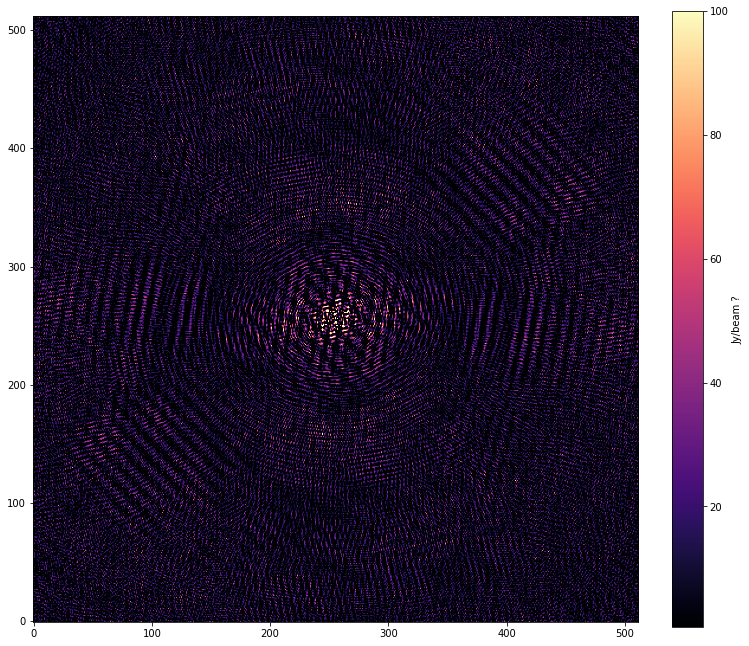

In [78]:
def plot_dirty_image(vis_gridded): 
    dirty_image = npix ** 2 * np.fft.fftshift(np.fft.ifft2(vis_gridded))[::-1].real
    plt.figure(figsize = (12, 12))
    im = plt.imshow(np.rot90(dirty_image[2048-256:2048+256, 2048-256:2048+256], k = 2), origin = "lower", cmap = "magma", vmin = 0.5, vmax = 100)  # flip needed due to CASA's convention  
    plt.colorbar(im, fraction = 0.046, label = "Jy/beam ?")
    
dirty_image = plot_dirty_image(vis_grid)

In [79]:
from scipy.ndimage import gaussian_filter

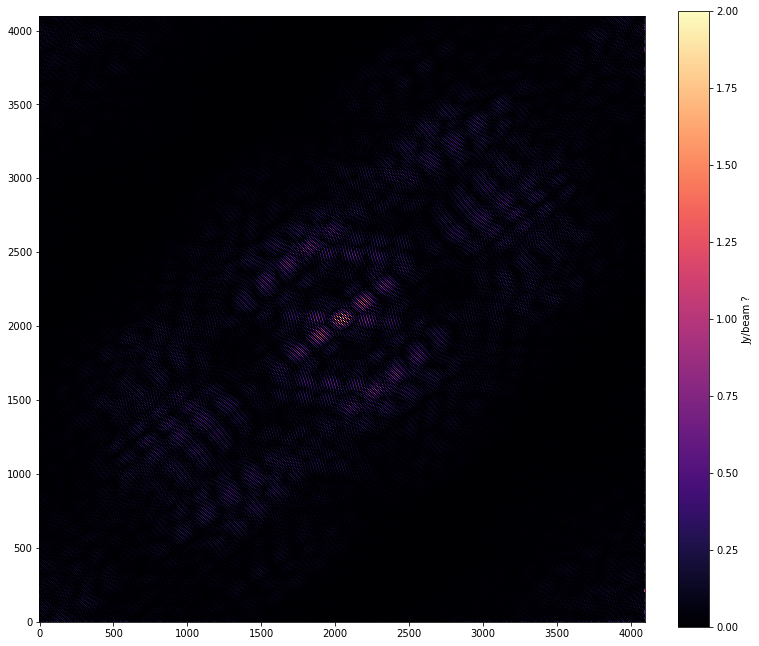

In [99]:
def plot_dirty_image(vis_gridded): 
    dirty_image = npix ** 2 * np.fft.fftshift(np.fft.ifft2(vis_gridded))[::-1].real
    plt.figure(figsize = (12, 12))
    im = plt.imshow(np.rot90(gaussian_filter(dirty_image, sigma = 3, mode = "nearest"), k = 2), origin = "lower", cmap = "magma", vmin = 0, vmax = 2)  # flip needed due to CASA's convention  
    plt.colorbar(im, fraction = 0.046, label = "Jy/beam ?")
    
dirty_image = plot_dirty_image(vis_grid)

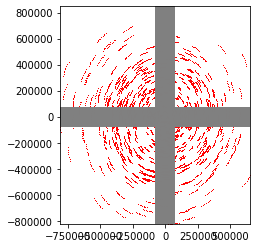

In [94]:
plot_uv_coverage(u, v, grid = True)